In [209]:
import pyLDAvis
import numpy as np
import pandas as pd
import re
import gensim
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Label
from bokeh.io import output_notebook
from pprint import pprint
import seaborn as sns

# Load Data

In [210]:
dictionary = gensim.corpora.Dictionary.load('../clean-data/fine-scale/UK/dictionary.dict')
corpus = gensim.corpora.MmCorpus('../clean-data/fine-scale/UK/corpus.mm')
lda = gensim.models.ldamulticore.LdaMulticore.load('../models/fine-scale/UK/model_101_topics')

In [211]:
lda.minimum_probability

0.01

## Plot TSNE

Create document_topic probability matrix

In [213]:
#topics
N = len(corpus)
res = np.zeros((lda.num_topics, N))

for i in range(0,N):
    topic_probs = lda.get_document_topics(corpus[i])
    for j in topic_probs:
        res[j[0],i] = j[1]

In [214]:
#filter docs with no topics
no_topic_index = np.sum(res, axis = (0)) > 0.0

sum(no_topic_index)

47918

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:ylabel='Count'>

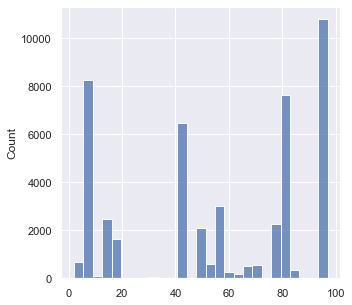

In [215]:
sns.set(rc={'figure.figsize':(5,5)})

# for each document, what is the biggest topic?
sns.histplot(np.argmax(res[:,no_topic_index], axis = 0))

In [226]:
(sum(no_topic_index)) ** 0.5

218.90180446949267

Fit TSNE to the matrix

In [234]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca',perplexity=100, n_iter=5000)
tsne_lda = tsne_model.fit_transform(res[:,no_topic_index].transpose())

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 47918 samples in 0.002s...
[t-SNE] Computed neighbors for 47918 samples in 28.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 47918
[t-SNE] Computed conditional probabilities for sample 2000 / 47918
[t-SNE] Computed conditional probabilities for sample 3000 / 47918
[t-SNE] Computed conditional probabilities for sample 4000 / 47918
[t-SNE] Computed conditional probabilities for sample 5000 / 47918
[t-SNE] Computed conditional probabilities for sample 6000 / 47918
[t-SNE] Computed conditional probabilities for sample 7000 / 47918
[t-SNE] Computed conditional probabilities for sample 8000 / 47918
[t-SNE] Computed conditional probabilities for sample 9000 / 47918
[t-SNE] Computed conditional probabilities for sample 10000 / 47918
[t-SNE] Computed conditional probabilities for sample 11000 / 47918
[t-SNE] Computed conditional probabilities for sample 12000 / 47918
[t-SNE] Computed conditional probabilities for s

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.680931
[t-SNE] KL divergence after 5000 iterations: 1.423798


get dataframe with ordinated positions

In [228]:
#index to match removed docs 
index = [i for (i,v) in enumerate(no_topic_index) if v]

TSNE_df = pd.DataFrame(tsne_lda,columns=["ax1","ax2"], index = index)
TSNE_df["topic"] = np.argmax(res[:,no_topic_index], axis = 0)

TSNE_df.head()

,ax1,ax2,topic
0,83.586136,0.943648,94
1,-14.377536,40.637669,69
2,-13.611654,82.180458,44
3,-48.218151,39.301094,81
4,-23.813433,12.295773,81


Plot docs in topic space with TSNE. Each point is one document and colors show the main topic. 

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


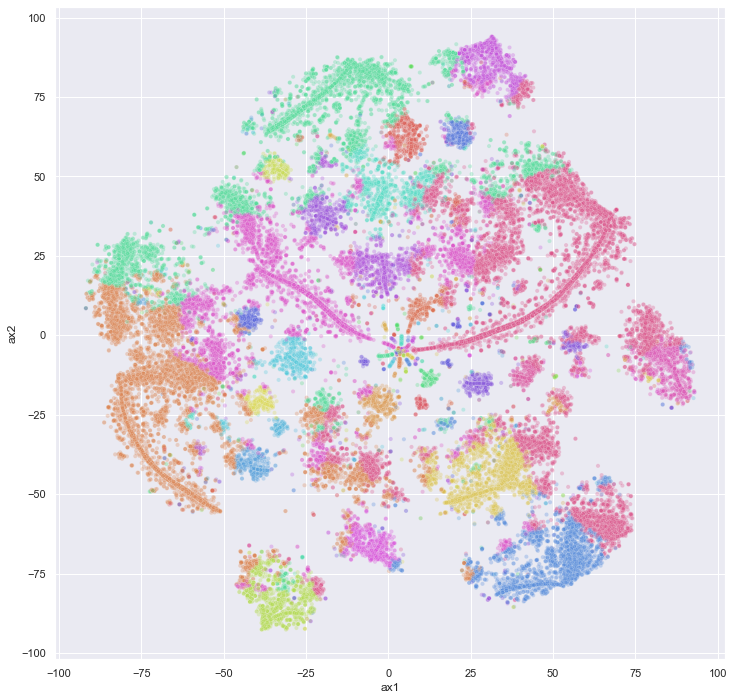

In [229]:
sns.set(rc={'figure.figsize':(12,12)})

p = sns.scatterplot(
    x="ax1", y="ax2",
    hue="topic",
    palette=sns.color_palette("hls",len(set(TSNE_df["topic"]))),
    data=TSNE_df,
    legend="full",
    alpha=0.3,
    size = 0.1  
)

p.legend_.remove()

## Adding Metadata

load in metadata and bind with TSNE ordination

In [230]:
#read in metadata
ukri_metadata = pd.read_csv("../raw-data/fine-scale/UK/UKRI_general.csv")

#read in ordered project ID 
ukri_project_ordered = pd.read_csv("../clean-data/fine-scale/UK/projectID_corpus.txt",header=None,names=["ProjectId"])

#add docId column
ukri_project_ordered["docId"] = ukri_project_ordered.index.astype("object")
#remove .txt from end
ukri_project_ordered["ProjectId"] = ukri_project_ordered["ProjectId"].apply(lambda x: re.sub(".txt","",x))

#subset metadata_cols
ukri_metadata = ukri_metadata[["FundingOrgName","LeadROName","Department","ProjectCategory","AwardPounds","ProjectId"]]

#join
ukri_metadata = ukri_project_ordered.set_index("ProjectId").join(ukri_metadata.set_index("ProjectId"))
ukri_metadata_TSNE = TSNE_df.join(ukri_metadata.set_index("docId"))

ukri_metadata_TSNE.head()

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,ax1,ax2,topic,FundingOrgName,LeadROName,Department,ProjectCategory,AwardPounds
0,83.586136,0.943648,94,MRC,University of Oxford,The Jenner Institute,Research Grant,1274897.0
1,-14.377536,40.637669,69,EPSRC,University of Southampton,School of Chemistry,Research Grant,916817.0
2,-13.611654,82.180458,44,MRC,London Sch of Hygiene and Trop Medicine,Epidemiology and Population Health,Research Grant,50405.0
3,-48.218151,39.301094,81,AHRC,University of Southampton,Faculty of Humanities,Fellowship,250740.0
4,-23.813433,12.295773,81,MRC,University College London,UNLISTED,Fellowship,175851.0


## Meta data transforming

### Log awards

pounds awarded is very skeweds so we log transform

In [231]:
ukri_metadata_TSNE = ukri_metadata_TSNE.query("AwardPounds > 0", engine='python')

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


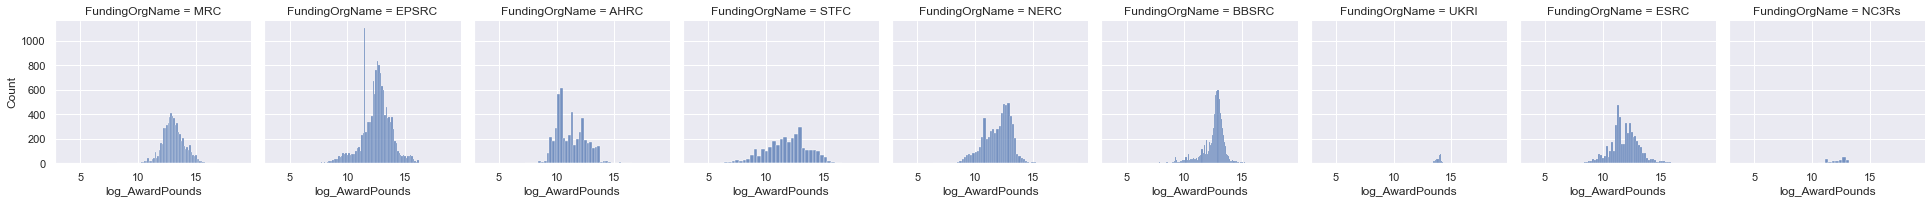

In [232]:
ukri_metadata_TSNE["log_AwardPounds"] = np.log(ukri_metadata_TSNE["AwardPounds"])

sns.set(rc={'figure.figsize':(5,5)})

g = sns.FacetGrid(ukri_metadata_TSNE, col="FundingOrgName")
g.map(sns.histplot, "log_AwardPounds")

## Plot By Funding Body

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


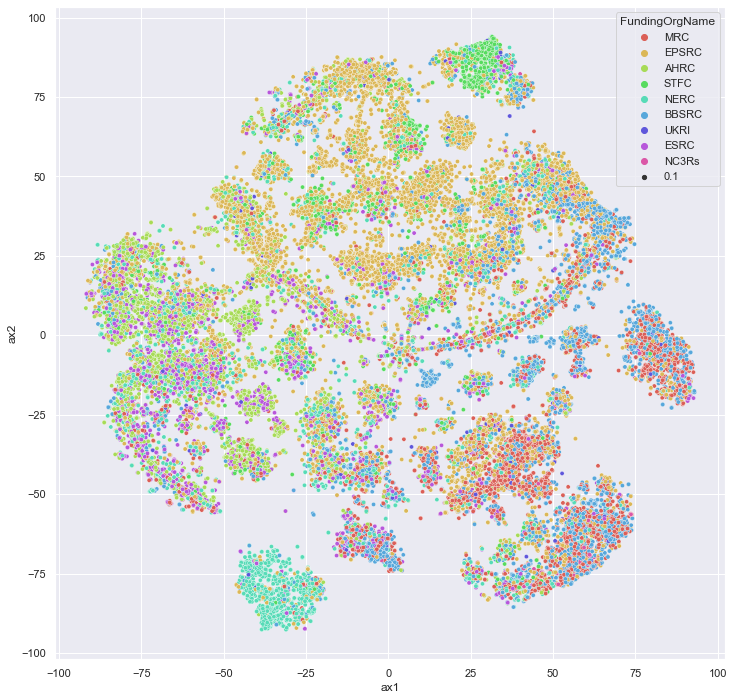

In [233]:
sns.set(rc={'figure.figsize':(12,12)})

p = sns.scatterplot(
    x="ax1", y="ax2",
    hue="FundingOrgName",
    palette=sns.color_palette("hls",len(set(ukri_metadata_TSNE["FundingOrgName"]))),
    data=ukri_metadata_TSNE,
    legend="full",
    alpha=1.0,
    size = 0.1  
)

# p.legend_.remove()

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


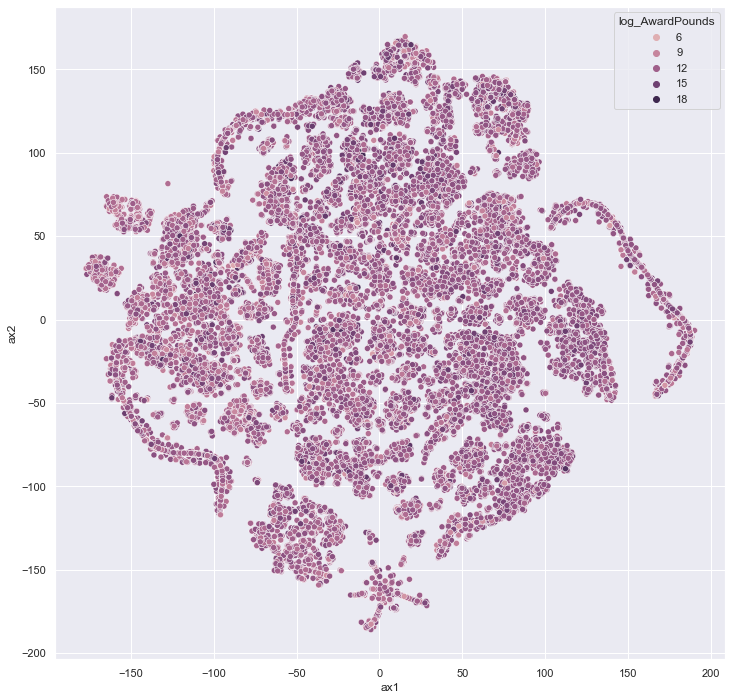

In [188]:
sns.set(rc={'figure.figsize':(12,12)})

# x = ukri_metadata_TSNE.head(n = 10000)

p = sns.scatterplot(
    x="ax1", y="ax2",
    hue="log_AwardPounds",
    # palette= sns.light_palette("seagreen", as_cmap=True),
    data=ukri_metadata_TSNE,
    alpha = 1)

# p.legend_.remove()

In [189]:
cuts = pd.DataFrame({feature + 'Bin' : pd.cut(x = ukri_metadata_TSNE[feature], bins = 100) for feature in ["ax1", "ax2"]})
means = ukri_metadata_TSNE.join(cuts).groupby( ["ax1Bin","ax2Bin"] ).agg({"ax1":"mean","ax2":"mean","log_AwardPounds":"mean"})

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='ax1', ylabel='ax2'>

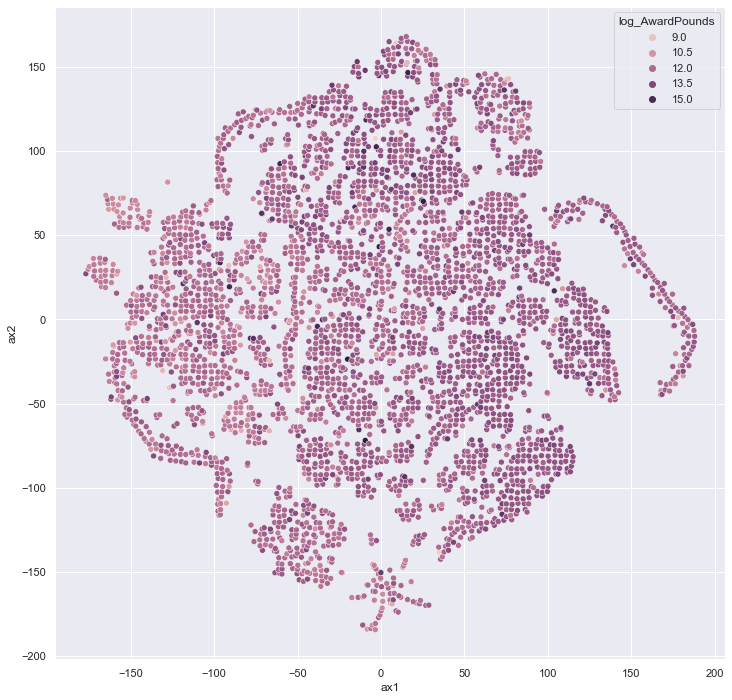

In [190]:
sns.set(rc={'figure.figsize':(12,12)})

sns.scatterplot(x="ax1",y="ax2",
                hue = "log_AwardPounds", 
                data = means.reset_index(),
                alpha = 1.0)

## Research Org

In [191]:
ukri_metadata_TSNE_OR_filter = ukri_metadata_TSNE.groupby("LeadROName").filter(lambda x : len(x) > 2000)

ukri_metadata_TSNE_OR_filter.head()

,ax1,ax2,topic,FundingOrgName,LeadROName,Department,ProjectCategory,AwardPounds,log_AwardPounds
0,120.856293,-12.667631,94,MRC,University of Oxford,The Jenner Institute,Research Grant,1274897.0,14.058376
4,-50.358303,1.992206,81,MRC,University College London,UNLISTED,Fellowship,175851.0,12.077392
5,-94.809387,76.349136,44,STFC,University of Cambridge,Applied Maths and Theoretical Physics,Research Grant,9200.0,9.126959
7,133.703903,-12.442756,82,BBSRC,University College London,Institute of Child Health,Research Grant,465998.0,13.051937
11,-36.024921,-8.070221,44,EPSRC,University of Manchester,Manchester Business School,Research Grant,268769.0,12.501608


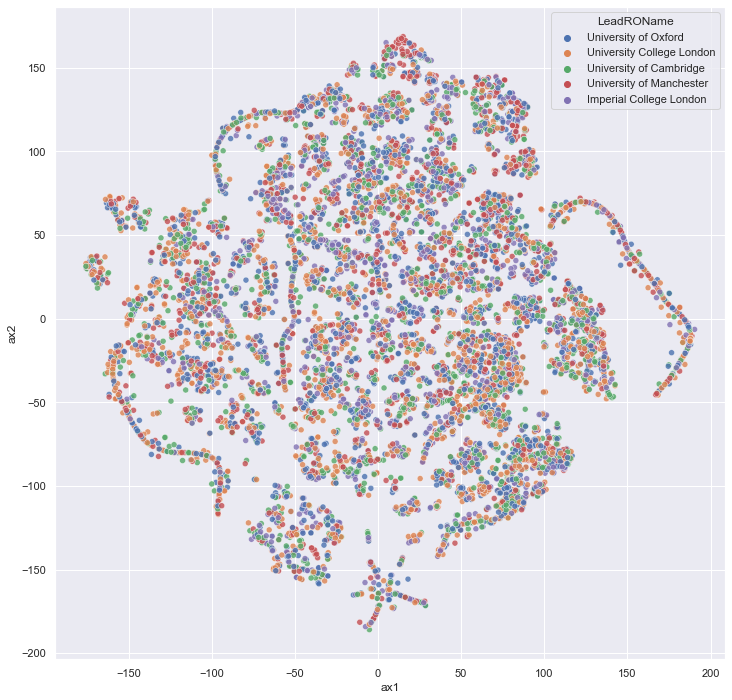

In [192]:
#By institution
p = sns.scatterplot(
    x="ax1", y="ax2",
    hue="LeadROName",
    # palette= sns.light_palette("seagreen", as_cmap=True),
    data=ukri_metadata_TSNE_OR_filter,
    alpha = 0.8)

# p.legend_.remove()

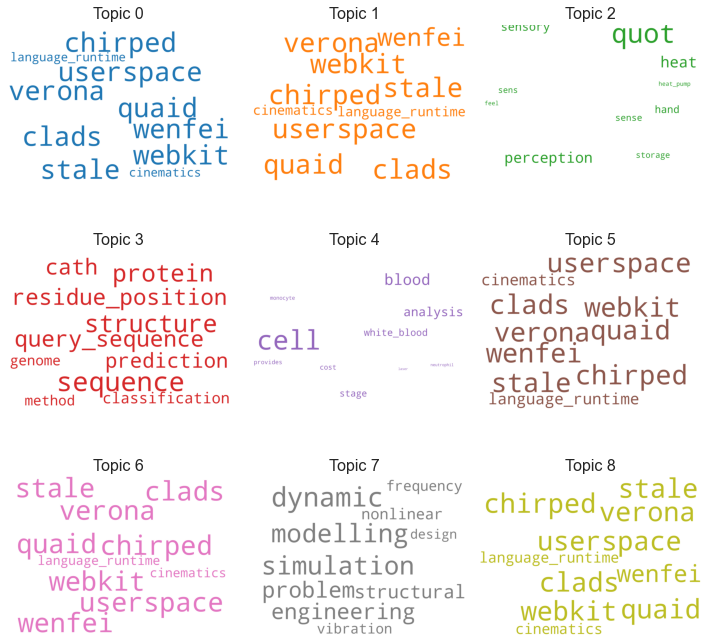

In [195]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 
'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 
'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab16',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


32826

In [208]:
ukri_project_ordered[ukri_project_ordered["docId"]== np.argmax(res[6,:], axis=0)]

,ProjectId,docId
32826,811EBCCA-472A-4E55-BF33-87D226F77A61,32826


In [ ]:
import pyLDAvis.gensim_models

x = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

pyLDAvis.display(x)